In [47]:
#Imports

#path tools
from pathlib import Path
import os

#image processing
from skimage.io import imread, imshow
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d

#other utils
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.contingency import margins #compute marginals
from scipy.optimize import curve_fit

wd = Path(os.getcwd()) #current working directory
np.seterr(divide='ignore'); #doesn't end up mattering, suppress the annoying warning

In [97]:
data_dir = Path("../data/mar09/MOT_current") #test data directory

#each image has an accompanying background image with just noise
im0 = imread(data_dir / "image_16_0.tif")
im0_background = imread(data_dir / "image_16_2.tif")

#I am unclear on why the second image is necessary
im1 = imread(data_dir / "image_16_1.tif")
im1_background = imread(data_dir / "image_16_3.tif")

/tmp/ipykernel_265167/789046457.py:10: RuntimeWarning: invalid value encountered in divide
  I_div_arr = np.divide(I_arr, I0_arr)


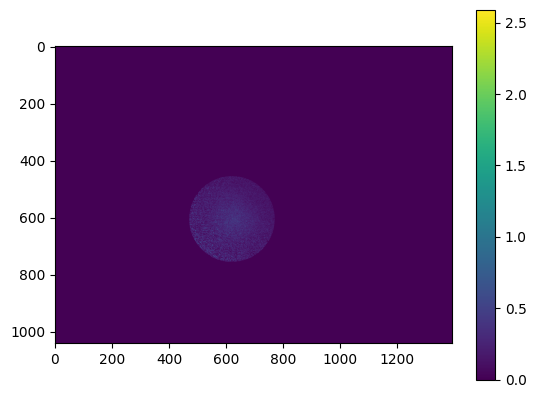

In [107]:
#get background intensity value with noise subtracted
I0_arr=np.subtract(np.array(im0),
                    np.array(im0_background)).astype(int)

#get foreground intensity with noise subtracted
I_arr=np.subtract(np.array(im1),
                    np.array(im1_background)).astype(int)


I_div_arr = np.divide(I_arr, I0_arr)
od_arr = np.log(I_div_arr)

def incircle(center, radius, pt):
    return (pt[0]-center[0])**2 + (pt[1]-center[1])**2 < radius**2
    #return True

#first pass, just clip anything not within the aperture
for i,row in enumerate(od_arr):
    for j, pixel in enumerate(row):
        if pixel < 0 or not incircle((605,620),150,(i,j)):
            od_arr[i][j] = 0

img1 = plt.imshow(od_arr)
plt.colorbar(img1)

## Create image mask
A couple parameters can be used to mask out the unwanted data. First, `lower_mask` and `upper_mask` are just rough cutoff values. The `value_mask` parameter tries to get as much of the blob as possible while cutting off the noise. This can be set low, because the median mask will eliminate the outliers.

4817


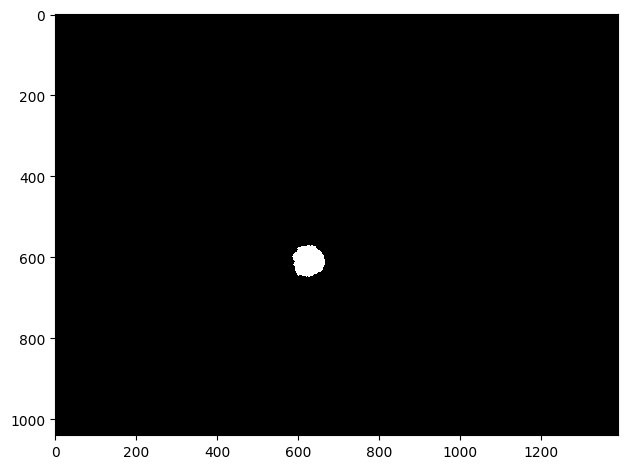

In [108]:
mask = od_arr[:,:] > threshhold
mask = median_filter(mask, 50)
print(np.sum(mask))
imshow(mask)

## Get blob bounding box
THe `label` function is used to separate contiguous regions of the image and returns useful properties regarding their shape, location, and orientation.

In [115]:
blobs = label(mask)
props = regionprops(blobs) #generate a properties dictionary
y,x = props[0].centroid

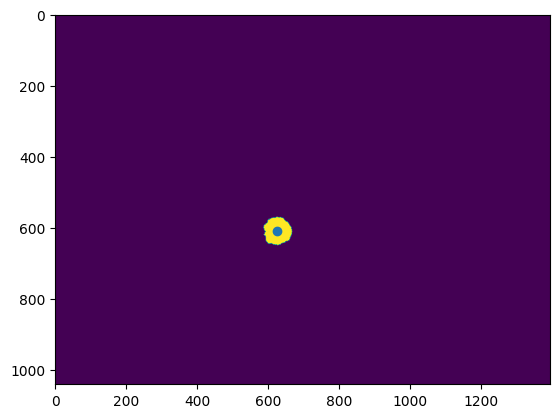

In [110]:
plt.imshow(mask)
plt.scatter(x, y)

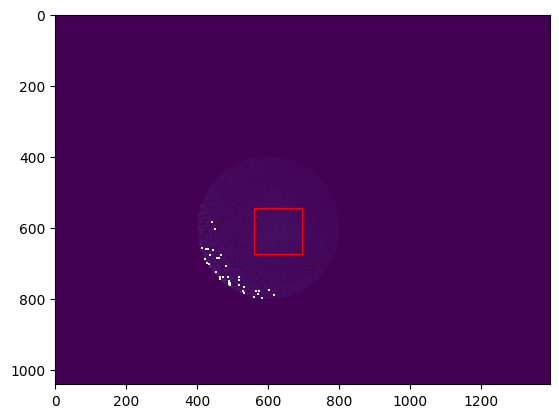

In [15]:
#draw bounding box
fig, ax = plt.subplots()
rect = plt.Rectangle((bbox[1],bbox[0]),bbox[3]-bbox[1], bbox[2]-bbox[0])
rect.set(fill=False, color = "red")
ax.add_artist(rect)
ax.imshow(od_arr)

In [116]:
#extract blob rectangle from image
blob_arr = od_arr[round(y)-200:round(y)+200, round(x)-200:round(x)+200]

In [117]:
#compute marginals and fit to a gaussian
def gaussian_fit(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

x, y = margins(blob_arr)
x = x.T[0]
y = y[0]

popt_x, pcov_x = curve_fit(gaussian_fit, np.arange(len(x)), x, p0 =[350, 150, 60])
popt_y, pcov_y = curve_fit(gaussian_fit, np.arange(len(y)), y, [350,150,60])

<ErrorbarContainer object of 3 artists>

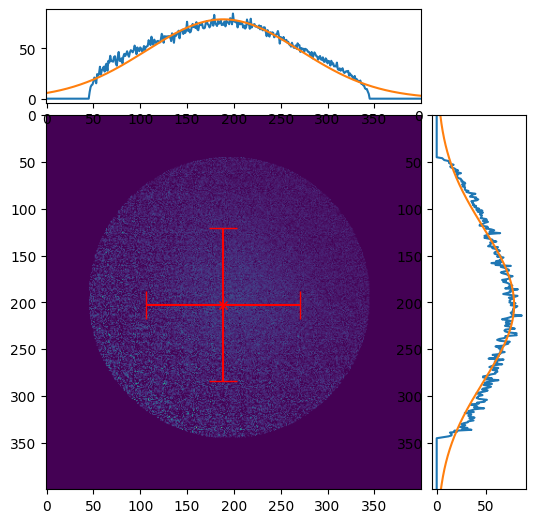

In [118]:
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
ax.imshow(blob_arr)

#axes are flipped!!
ax_y = fig.add_subplot(gs[0,0], sharex=ax)
ax_x = fig.add_subplot(gs[1,1], sharey=ax)

ax_y.plot(y)
ax_y.plot(np.arange(len(y)), gaussian_fit(np.arange(len(y)),*popt_y))

ax_x.plot(x, np.arange(len(x)))
ax_x.plot(gaussian_fit(np.arange(len(x)),*popt_x),np.arange(len(x)))

ax.errorbar(popt_y[1], popt_x[1], xerr = popt_y[2], yerr = popt_x[2], color = 'r', marker = "x", capsize = 10)

In [15]:
popt_x[1]

184.61786717934694

In [16]:
print("OD max:", np.max(blob_arr))

OD max: 2.0828603484286212
